In [336]:
import sqlite3

import matplotlib.pyplot as plt
import pandas as pd

conn = sqlite3.connect("../data/conditions.db")

query = """
SELECT age, gender, patient
FROM (
    SELECT c.patient, p.gender, DATE(p.birthdate) as dob, min(DATE(c.start)) as start, (cast(strftime('%Y.%m%d', min(DATE(c.start))) - strftime('%Y.%m%d', DATE(p.birthdate)) as int) / 2) * 2 as age
    FROM conditions c
    JOIN patients p on c.patient = p.id
    WHERE c.description = 'Ischemic heart disease (disorder)'
    GROUP BY c.patient
    ORDER BY age
 ) h
WHERE age >= 20;
"""


df = pd.read_sql(query, conn)
df

,age,gender,patient
0,40,F,0220e8b3-e108-768c-dfcf-22ad951ae7ac
1,40,M,034f2cbf-41f7-53b5-9cbb-9c69f3c3ae1e
2,40,F,03b204cd-c4e6-30a0-57f2-7f7e182da896
3,40,M,04b64150-7905-97c4-6ce7-12134e09b24c
4,40,M,04d185d2-0af9-a96a-a035-0b22861e0e51
...,...,...,...
9231,80,F,e89dd75a-f0fc-3bdf-a062-ac047cf72e33
9232,80,F,ea0c6652-cb7f-e564-0e17-ce251bd074c0
9233,80,F,f0b72501-8806-4cbf-31e2-541c5913bc87
9234,80,F,f99d16b5-ca1b-1fda-820c-096878b91d30


In [337]:
womenMeanDf = df.where(df.gender == "F").dropna().mean()
menMeanDf = df.where(df.gender == "M").dropna().mean()

C:\Users\krist\AppData\Local\Temp\ipykernel_20580\3459853752.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  womenMeanDf = df.where(df.gender == "F").dropna().mean()
C:\Users\krist\AppData\Local\Temp\ipykernel_20580\3459853752.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  menMeanDf = df.where(df.gender == "M").dropna().mean()


MALES Below


In [338]:
import numpy.random as np
howManyMenQuery = """
SELECT COUNT(*) as count
FROM (
    SELECT c.patient, p.gender, DATE(p.birthdate) as dob, min(DATE(c.start)) as start, (cast(strftime('%Y.%m%d', min(DATE(c.start))) - strftime('%Y.%m%d', DATE(p.birthdate)) as int) / 2) * 2 as age
    FROM conditions c
    JOIN patients p on c.patient = p.id
    WHERE c.description = 'Ischemic heart disease (disorder)'
    GROUP BY c.patient
    ORDER BY age
 ) h
WHERE age >= 20 and gender = 'M'
ORDER by gender
;
"""

maxMaleQuery = """
SELECT MAX(age)
FROM (
    SELECT c.patient, p.gender, DATE(p.birthdate) as dob, min(DATE(c.start)) as start, (cast(strftime('%Y.%m%d', min(DATE(c.start))) - strftime('%Y.%m%d', DATE(p.birthdate)) as int) / 2) * 2 as age
    FROM conditions c
    JOIN patients p on c.patient = p.id
    WHERE c.description = 'Ischemic heart disease (disorder)'
    GROUP BY c.patient
    ORDER BY age
 ) h
WHERE age >= 20 and gender = 'M'
ORDER by gender
;
"""


howManyMenDF = pd.read_sql(howManyMenQuery, conn)
maxMaleDF = pd.read_sql(maxMaleQuery, conn)
nOfMen = int(howManyMenDF.to_string(index=False, header=False))
maxMaleage = int(maxMaleDF.to_string(index=False, header=False))


print(nOfMen)
menavg = menMeanDf["age"].astype(float)

5792


FEMALES below

In [339]:
maxFemaleQuery = """
SELECT MAX(age)
FROM (
    SELECT c.patient, p.gender, DATE(p.birthdate) as dob, min(DATE(c.start)) as start, (cast(strftime('%Y.%m%d', min(DATE(c.start))) - strftime('%Y.%m%d', DATE(p.birthdate)) as int) / 2) * 2 as age
    FROM conditions c
    JOIN patients p on c.patient = p.id
    WHERE c.description = 'Ischemic heart disease (disorder)'
    GROUP BY c.patient
    ORDER BY age
 ) h
WHERE age >= 20 and gender = 'F'
ORDER by gender
;
"""

howManyWomenQuery = """
SELECT count(*) as count
FROM (
    SELECT c.patient, p.gender, DATE(p.birthdate) as dob, min(DATE(c.start)) as start, (cast(strftime('%Y.%m%d', min(DATE(c.start))) - strftime('%Y.%m%d', DATE(p.birthdate)) as int) / 2) * 2 as age
    FROM conditions c
    JOIN patients p on c.patient = p.id
    WHERE c.description = 'Ischemic heart disease (disorder)'
    GROUP BY c.patient
    ORDER BY age
 ) h
WHERE age >= 20 and gender = 'F'
ORDER by gender
;
"""


howManyWomenDF = pd.read_sql(howManyWomenQuery, conn)
nOfWomen = int(howManyWomenDF.to_string(index=False, header=False))
maxFemaleDF = pd.read_sql(maxFemaleQuery, conn)
maxFemaleAge = int(maxMaleDF.to_string(index=False, header=False))

print(nOfWomen)
womenavg = womenMeanDf["age"].astype(float)


3444


Make a distribution for both men and women

3.9213396987955704
58.84188531901104


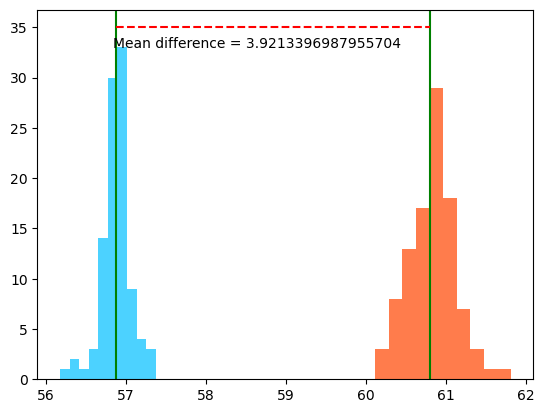

In [340]:
import numpy.random as np
import numpy as npp
menArr = []
womenArr = []

for i in range(100):

    deltaWomen = maxFemaleAge / nOfWomen
    scaleWomen = deltaWomen / 0.1
    lapWomen = np.laplace(0, scaleWomen)

    womenArr.append(womenavg+lapWomen)

    delta = maxMaleage / nOfMen
    scale = delta / 0.1
    lap = np.laplace(0, scale)

    menArr.append(menavg+lap)



plt.hist(menArr, color="deepskyblue", alpha=0.7)
plt.axvline(x=womenavg, color="g")
plt.axvline(x=menavg, color ="g")

x= [menavg, womenavg]
y=[35, 35]

plt.plot(x, y, linestyle="--", color="r")

difference = womenavg-menavg
print(difference)
swag = (womenavg+menavg) / 2
print(swag)
plt.text(swag-2, 33, "Mean difference = " + str(difference))



plt.hist(womenArr, color="orangered", alpha=0.7)
plt.show()


With DP

In [341]:
# calculate the Cohen's d between two samples
from numpy import mean
from numpy import var
from math import sqrt

# function to calculate Cohen's d for independent samples
def cohend(d1, d2):
    # calculate the size of samples
    n1, n2 = len(d1), len(d2)
    # calculate the variance of the samples
    s1, s2 = var(d1, ddof=1), var(d2, ddof=1)
    # calculate the pooled standard deviation
    s = sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    # calculate the means of the samples
    u1, u2 = mean(d1), mean(d2)
    # calculate the effect size
    return (u1 - u2) / s

dBDP = cohend(womenArr, menArr)
print("After DP, for men and women: ", dBDP)


After DP, for men and women:  16.012063017787636


Try with the epsilon vs effect size in this experiment



In [342]:

# Python program to illustrate
# enumerate function
import numpy as np

for  i in np.arange(0.5, 1.5, 0.2):
    print(i, end =" ")#%%
import sqlite3

import matplotlib.pyplot as plt
import pandas as pd

conn = sqlite3.connect("../data/conditions.db")

query = """
SELECT age, gender, patient
FROM (
    SELECT c.patient, p.gender, DATE(p.birthdate) as dob, min(DATE(c.start)) as start, (cast(strftime('%Y.%m%d', min(DATE(c.start))) - strftime('%Y.%m%d', DATE(p.birthdate)) as int) / 2) * 2 as age
    FROM conditions c
    JOIN patients p on c.patient = p.id
    WHERE c.description = 'Ischemic heart disease (disorder)'
    GROUP BY c.patient
    ORDER BY age
 ) h
WHERE age >= 20;
"""


df = pd.read_sql(query, conn)
df

0.5 0.7 0.8999999999999999 1.0999999999999999 1.2999999999999998 

,age,gender,patient
0,40,F,0220e8b3-e108-768c-dfcf-22ad951ae7ac
1,40,M,034f2cbf-41f7-53b5-9cbb-9c69f3c3ae1e
2,40,F,03b204cd-c4e6-30a0-57f2-7f7e182da896
3,40,M,04b64150-7905-97c4-6ce7-12134e09b24c
4,40,M,04d185d2-0af9-a96a-a035-0b22861e0e51
...,...,...,...
9231,80,F,e89dd75a-f0fc-3bdf-a062-ac047cf72e33
9232,80,F,ea0c6652-cb7f-e564-0e17-ce251bd074c0
9233,80,F,f0b72501-8806-4cbf-31e2-541c5913bc87
9234,80,F,f99d16b5-ca1b-1fda-820c-096878b91d30


In [343]:
womenMeanDf = df.where(df.gender == "F").dropna().mean()
menMeanDf = df.where(df.gender == "M").dropna().mean()

C:\Users\krist\AppData\Local\Temp\ipykernel_20580\3459853752.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  womenMeanDf = df.where(df.gender == "F").dropna().mean()
C:\Users\krist\AppData\Local\Temp\ipykernel_20580\3459853752.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  menMeanDf = df.where(df.gender == "M").dropna().mean()


MALES Below


In [344]:
import numpy.random as np
howManyMenQuery = """
SELECT COUNT(*) as count
FROM (
    SELECT c.patient, p.gender, DATE(p.birthdate) as dob, min(DATE(c.start)) as start, (cast(strftime('%Y.%m%d', min(DATE(c.start))) - strftime('%Y.%m%d', DATE(p.birthdate)) as int) / 2) * 2 as age
    FROM conditions c
    JOIN patients p on c.patient = p.id
    WHERE c.description = 'Ischemic heart disease (disorder)'
    GROUP BY c.patient
    ORDER BY age
 ) h
WHERE age >= 20 and gender = 'M'
ORDER by gender
;
"""

maxMaleQuery = """
SELECT MAX(age)
FROM (
    SELECT c.patient, p.gender, DATE(p.birthdate) as dob, min(DATE(c.start)) as start, (cast(strftime('%Y.%m%d', min(DATE(c.start))) - strftime('%Y.%m%d', DATE(p.birthdate)) as int) / 2) * 2 as age
    FROM conditions c
    JOIN patients p on c.patient = p.id
    WHERE c.description = 'Ischemic heart disease (disorder)'
    GROUP BY c.patient
    ORDER BY age
 ) h
WHERE age >= 20 and gender = 'M'
ORDER by gender
;
"""


howManyMenDF = pd.read_sql(howManyMenQuery, conn)
maxMaleDF = pd.read_sql(maxMaleQuery, conn)
nOfMen = int(howManyMenDF.to_string(index=False, header=False))
maxMaleage = int(maxMaleDF.to_string(index=False, header=False))


print(nOfMen)
menavg = menMeanDf["age"].astype(float)

5792


FEMALES below

In [345]:
maxFemaleQuery = """
SELECT MAX(age)
FROM (
    SELECT c.patient, p.gender, DATE(p.birthdate) as dob, min(DATE(c.start)) as start, (cast(strftime('%Y.%m%d', min(DATE(c.start))) - strftime('%Y.%m%d', DATE(p.birthdate)) as int) / 2) * 2 as age
    FROM conditions c
    JOIN patients p on c.patient = p.id
    WHERE c.description = 'Ischemic heart disease (disorder)'
    GROUP BY c.patient
    ORDER BY age
 ) h
WHERE age >= 20 and gender = 'F'
ORDER by gender
;
"""

howManyWomenQuery = """
SELECT count(*) as count
FROM (
    SELECT c.patient, p.gender, DATE(p.birthdate) as dob, min(DATE(c.start)) as start, (cast(strftime('%Y.%m%d', min(DATE(c.start))) - strftime('%Y.%m%d', DATE(p.birthdate)) as int) / 2) * 2 as age
    FROM conditions c
    JOIN patients p on c.patient = p.id
    WHERE c.description = 'Ischemic heart disease (disorder)'
    GROUP BY c.patient
    ORDER BY age
 ) h
WHERE age >= 20 and gender = 'F'
ORDER by gender
;
"""


howManyWomenDF = pd.read_sql(howManyWomenQuery, conn)
nOfWomen = int(howManyWomenDF.to_string(index=False, header=False))
maxFemaleDF = pd.read_sql(maxFemaleQuery, conn)
maxFemaleAge = int(maxMaleDF.to_string(index=False, header=False))

print(nOfWomen)
womenavg = womenMeanDf["age"].astype(float)


3444


Make a distribution for both men and women

3.9213396987955704
58.84188531901104


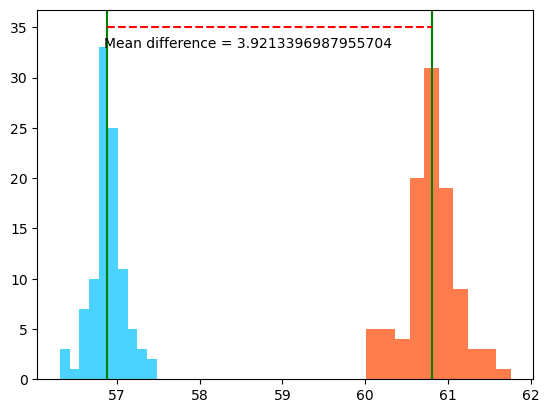

In [346]:
import numpy.random as np
import numpy as npp
menArr = []
womenArr = []

for i in range(100):

    deltaWomen = maxFemaleAge / nOfWomen
    scaleWomen = deltaWomen / 0.1
    lapWomen = np.laplace(0, scaleWomen)

    womenArr.append(womenavg+lapWomen)

    delta = maxMaleage / nOfMen
    scale = delta / 0.1
    lap = np.laplace(0, scale)

    menArr.append(menavg+lap)



plt.hist(menArr, color="deepskyblue", alpha=0.7)
plt.axvline(x=womenavg, color="g")
plt.axvline(x=menavg, color ="g")

x= [menavg, womenavg]
y=[35, 35]

plt.plot(x, y, linestyle="--", color="r")

difference = womenavg-menavg
print(difference)
swag = (womenavg+menavg) / 2
print(swag)
plt.text(swag-2, 33, "Mean difference = " + str(difference))



plt.hist(womenArr, color="orangered", alpha=0.7)
plt.show()


With DP

In [347]:
# calculate the Cohen's d between two samples
from numpy import mean
from numpy import var
from math import sqrt

# function to calculate Cohen's d for independent samples
def cohend(d1, d2):
    # calculate the size of samples
    n1, n2 = len(d1), len(d2)
    # calculate the variance of the samples
    s1, s2 = var(d1, ddof=1), var(d2, ddof=1)
    # calculate the pooled standard deviation
    s = sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    # calculate the means of the samples
    u1, u2 = mean(d1), mean(d2)
    # calculate the effect size
    return (u1 - u2) / s

dBDP = cohend(womenArr, menArr)
print("After DP, for men and women: ", dBDP)

After DP, for men and women:  14.734667553725266


Try with the epsilon vs effect size in this experiment



In [364]:

# Python program to illustrate
# enumerate function
import numpy.random as np
import numpy as npp
menArr = [[] for _ in range(10)]
womenArr = [[] for _ in range(10)]
epsilons = []
cohends = []
count = 0

for  i in npp.arange(0.01, 1, 0.1):
    if i>0.02 : i = round(i,1)
    epsilons.append(i)

    for y in npp.arange(0,9,1):
        deltaWomen = maxFemaleAge / nOfWomen
        print(i)
        scaleWomen = deltaWomen / i
        lapWomen = np.laplace(0, scaleWomen)

        print(womenArr[count])
        womenArr[count].append(womenavg+lapWomen)


        delta = maxMaleage / nOfMen
        scale = delta / i
        lap = np.laplace(0, scale)
        menArr[count].append(menavg+lap)
    print(count)
    count = count + 1


print(womenArr)






0.01
[]
0.01
[57.22284599117458]
0.01
[57.22284599117458, 59.6653441551661]
0.01
[57.22284599117458, 59.6653441551661, 55.428925800686066]
0.01
[57.22284599117458, 59.6653441551661, 55.428925800686066, 61.075114328521856]
0.01
[57.22284599117458, 59.6653441551661, 55.428925800686066, 61.075114328521856, 62.52824546344634]
0.01
[57.22284599117458, 59.6653441551661, 55.428925800686066, 61.075114328521856, 62.52824546344634, 59.113988467137034]
0.01
[57.22284599117458, 59.6653441551661, 55.428925800686066, 61.075114328521856, 62.52824546344634, 59.113988467137034, 60.60002581933993]
0.01
[57.22284599117458, 59.6653441551661, 55.428925800686066, 61.075114328521856, 62.52824546344634, 59.113988467137034, 60.60002581933993, 61.213658866211254]
0
0.1
[]
0.1
[60.73099511511622]
0.1
[60.73099511511622, 60.660715732358604]
0.1
[60.73099511511622, 60.660715732358604, 61.2672085496633]
0.1
[60.73099511511622, 60.660715732358604, 61.2672085496633, 60.61208862999635]
0.1
[60.73099511511622, 60.66071